In [1]:
using Plots, Random, LaTeXStrings, BenchmarkTools, OperatorApproximation, LinearMaps, IterativeSolvers, EllipticFunctions, LinearAlgebra, RandomizedLinAlg

In [2]:
Plots.scalefontsizes(1.5)

In [3]:
include("/home/hdw27/Documents/AkhiezerSylvester/src/AkhiezerSylvester.jl")
include("/home/hdw27/Documents/AkhiezerSylvester/src/BS_ADI.jl")
include("/home/hdw27/Documents/AkhiezerSylvester/src/PolynomialKrylov.jl")

algorithm5 (generic function with 1 method)

#### Linear maps to generate matrices

In [4]:
#functions to map [-1,1] to [a,b] and vice versa
M = (a,b) ->  (x -> (b-a)/2*(x .+ (b+a)/(b-a)))
iM = (a,b) -> (x -> 2/(b-a)*(x .- (b+a)/2))

#27 (generic function with 1 method)

In [5]:
#functions to generate evenly-spaced points on the unit circle
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n
zgrid = n -> exp.(1im*mgrid(n,pi))

#33 (generic function with 1 method)

### Convergence rate bounds

In [ ]:
xv = 0:0.001:1
pke(x) = (sqrt(x+1)-sqrt(2x))/(sqrt(x+1)+sqrt(2x))
akhi(x) = (1-sqrt(x))/(1+sqrt(x))
akhs(x) = sqrt((1-x)/(1+x))

In [ ]:
p1 = plot(xv,pke,label=:"Polynomial Krylov")
plot!(xv,akhs,label=:"Method 1",linestyle=:dash)
plot!(xv,akhi,label=:"Method 2",linestyle=:dashdot)
xlabel!(L"\beta")
ylabel!("Convergence rate")

In [ ]:
savefig(p1,"conv_rate_bounds.pdf")

### Scalar approximation plots

In [ ]:
#function that gets the rational function parameters for the 2r+1 Zolotarev rational on [-1, -beta] \cup [beta, 1]
function  get_zolo_params(r, beta)
    
    idx = 1:2*r;
    m = 1-beta^2;
    Kval = ellipticK(m); #matlab first out for ellipke
    snv = jellip("sn",idx*Kval/(2*r.+1); m=m);
    cnv = jellip("cn",idx*Kval/(2*r.+1); m=m);
    c = real(beta^2*(snv.^2)./(cnv.^2))

    M =  sum( log.(1.0.+c[1:2:2*r]) +log.(1.0./(1.0.+c[2:2:2*r]))); 
    M =  real(exp(M));

  #=  a = zeros(1, r); 
    for j = 1:r
        cm = c[1:2:2*r]; 
        cm[j] = []; 
        a[j] = -prod(c(2*j-1)-c(2:2:2*r))*prod(c(2*j-1)-cm);
    end =#
    return M, c   
end

In [ ]:
function eval_zolo(M,c, x)
    out = ones(length(x),1); 
    for j = 1:(length(c)/2 |> Int )
      out .*= @. (x^2 + c[2*j])/(x^2 + c[2*j-1]); 
    end
    out = M.*x.*out;
    return out
end

In [ ]:
function zolo_range(pts,β; iter=50)
    vals = zeros(length(pts),ceil((iter-1)/2)+1 |> Int)
    for j = 0:(ceil((iter-1)/2) |> Int)
        M, c = get_zolo_params(j, β)
        vals[:,j+1] = eval_zolo(M, c, pts)
    end
    vals
end

In [ ]:
#Akhiezer polynomial approximation stored at each iteration
function poly_approx(x,avec,bvec,coeffs; maxiter=150)
    hist = zeros(ComplexF64,maxiter,1)
    fx = 0.
    for k = 0:maxiter-1
        if k == 0
            global y = 1.
        elseif k == 1
            global y = (x*ym1-avec[1]*ym1)/bvec[1]
            global ym2 = ym1
        else
            global y = (x*ym1-bvec[k-1]*ym2-avec[k]*ym1)/bvec[k]
            global ym2 = ym1
        end
        global ym1 = y

        fx += coeffs[k+1]*y
        hist[k+1] = fx
    end
    hist
end

In [ ]:
function get_err(sol_mat,tru_sol)
    err_vec = zeros(size(sol_mat,2))
    for j = 1:size(sol_mat,2)
        err_vec[j] = norm(sol_mat[:,j]-tru_sol,Inf)
    end
    err_vec
end

In [ ]:
for β in [1/8 1/4 1/2 3/4]
    bands = [-1 -β; β 1]
    param = get_params(bands,zeros(1,1),zeros(1,1); numiter=150)
    npts = 50
    pts = [range(-1, -β, npts); range(β, 1, npts)]

    poly1 = mapreduce(permutedims,vcat,map(x->poly_approx(x,param.avec,param.bvec,param.α), pts))
    zolo1 = zolo_range(pts,β)
    tru_sgn = [-ones(npts,1); ones(npts, 1)]
    err_poly = get_err(poly1,tru_sgn)
    err_zolo = get_err(zolo1,tru_sgn)

    p1 = plot(0:149,err_poly,yaxis=:log,label=:"Polynomial")
    plot!(2:4:102,err_zolo,label=:"Rational")
    xlabel!("Degrees of freedom")
    ylabel!("Max norm error")
    title!(L"[-1,-%$β]\cup[%$β,1]")
    yaxis!([1,1e-5,1e-10,1e-15])

    savefig(p1,"poly_rat_comp$β.pdf")
end
display(p1)

### Generalized Bernstein ellipse plots

In [ ]:
bands = [-2 -0.5; 0.5 6]

xv = bands[1,1]-0.2:0.01:bands[end,2]+0.2
yv = LinRange(-1.,1.,length(xv))
make_mat(x, y) = x+im*y
zv = @. make_mat(xv', yv);
gzp = map(z->get_n_coeffs_and_ints_akh(bands, 0, z)[4][1],zv);

In [ ]:
g0 = golden_section(bands)

p1 = contour(xv, yv, real.(gzp), levels=[0.005; 0.1; 0.17; 0.25], color=:black,colorbar=false)
contour!(xv, yv, real.(gzp), levels=[g0], linecolor=:red, linestyle=:dash, colorbar=false)
xlabel!(L"\mathrm{Re}(z)")
ylabel!(L"\mathrm{Im}(z)")

In [ ]:
savefig(p1,"bernstein1.pdf")

In [ ]:
bands = [-2 -0.1; 0.1 1.5]

xv = bands[1,1]-0.2:0.01:bands[end,2]+0.2
yv = LinRange(-0.5,0.5,length(xv))
make_mat(x, y) = x+im*y
zv = @. make_mat(xv', yv);
gzp = map(z->get_n_coeffs_and_ints_akh(bands, 0, z)[4][1],zv);

In [ ]:
g0 = golden_section(bands)

p2 = contour(xv, yv, real.(gzp), levels=[0.005; 0.04; 0.1; 0.27], color=:black,colorbar=false)
contour!(xv, yv, real.(gzp), levels=[g0], linecolor=:red, linestyle=:dash, colorbar=false)
xlabel!(L"\mathrm{Re}(z)")
ylabel!(L"\mathrm{Im}(z)")

In [ ]:
savefig(p2,"bernstein2.pdf")

### Weighted compression figures

In [ ]:
Random.seed!(123)

#generate dense positive definite matrices with eigenvalues 
evalrangeA = [2. 3.] #eigenvalues of A
evalrangeB = [0.5 1.8] #eigenvalues of B
N, N₂ = 1000, 900 #dimensions of A and B
r = 2 #rank of RHS

#generate B
μ2 = M(evalrangeB[1],evalrangeB[2])(2*rand(N₂).-1)
D = diagm(μ2)
P = rand(N₂,N₂)
Q,R = qr(P)
B = Q\(D*Q);

#generate A
μ = M(evalrangeA[1],evalrangeA[2])(2*rand(N).-1)
A = diagm(μ)
P = rand(N,N)
Q,R = qr(P)
A = Q\(A*Q)

bands = [-reverse(evalrangeB); evalrangeA] #eigenvalues of block system

#generate RHS
U = randn(N₂,r)
V = randn(r,N)

In [ ]:
tru_sln = sylvester(B,A,-U*V);

In [ ]:
param = get_params(bands,A,-B);

In [ ]:
W, Z, rJK, rWZ, erv = lowrank_block_svd(A,U,V,-B,param; get_resid=true, store_rank=true,tru_sol=tru_sln,use_weight_compress=false);

In [ ]:
p1 = plot(0:param.maxiter-1,rJK,label=L"\mathbf{J}_k\mathbf{K}_k")
plot!(1:param.maxiter,rWZ,label=L"\mathbf{W}_k\mathbf{Z}_k")
xlabel!(L"k")
ylabel!("Numerical rank")

In [ ]:
savefig(p1,"rank_iter.pdf")

In [ ]:
p2 = plot(1:param.maxiter,erv,yaxis=:log,label=:false)
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{W}_k\mathbf{Z}_k-\mathbf{X}_*\Vert_2")

In [ ]:
savefig(p2,"err_iter.pdf")

In [ ]:
W, Z, rJK, rWZ, erv = lowrank_block_svd(A,U,V,-B,param; get_resid=true, store_rank=true,tru_sol=tru_sln);

In [ ]:
p3 = plot(0:param.maxiter-1,rJK,label=L"\mathbf{J}_k\mathbf{K}_k")
plot!(1:param.maxiter,rWZ,label=L"\mathbf{W}_k\mathbf{Z}_k")
xlabel!(L"k")
ylabel!("Numerical rank")

In [ ]:
savefig(p3,"rank_iter_new.pdf")

In [ ]:
storage1 = [rJK[i] + (i > 1 ? rJK[i-1] : 0) + (i > 2 ? rJK[i-2] : 0) for i in 1:length(rJK)]+[rWZ[i] + (i > 1 ? rWZ[i-1] : 0)  for i in 1:length(rWZ)]
storage1 += [r; 2r; 3r*ones(length(storage1)-2)];

In [ ]:
p4 = plot(1:param.maxiter,erv,yaxis=:log,label=:false)
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{W}_k\mathbf{Z}_k-\mathbf{X}_*\Vert_2")

In [ ]:
savefig(p4,"err_iter_new.pdf")

### Repeat figures for Method 2

In [ ]:
params_inv = get_params_inv(bands,A,B)

In [ ]:
W, Z, rJK, rWZ, erv = sylv_operator_inv_low_rank(A,U,V,-B,params_inv; get_resid=true, store_rank=true,tru_sol=tru_sln,use_weight_compress=false);

In [ ]:
p1 = plot(0:params_inv.maxiter-1,rJK,label=L"\mathbf{J}_k\mathbf{K}_k")
plot!(1:params_inv.maxiter,rWZ,label=L"\mathbf{W}_k\mathbf{Z}_k")
xlabel!(L"k")
ylabel!("Numerical rank")

In [ ]:
savefig(p1,"rank_iter2.pdf")

In [ ]:
p2 = plot(1:params_inv.maxiter,erv,yaxis=:log,label=:false)
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{W}_k\mathbf{Z}_k-\mathbf{X}_*\Vert_F")

In [ ]:
savefig(p2,"err_iter2.pdf")

In [ ]:
W, Z, rJK, rWZ, erv = sylv_operator_inv_low_rank(A,U,V,-B,params_inv; get_resid=true, store_rank=true,tru_sol=tru_sln);

In [ ]:
p3 = plot(0:params_inv.maxiter-1,rJK,label=L"\mathbf{J}_k\mathbf{K}_k")
plot!(1:params_inv.maxiter,rWZ,label=L"\mathbf{W}_k\mathbf{Z}_k")
xlabel!(L"k")
ylabel!("Numerical rank")

In [ ]:
savefig(p3,"rank_iter_new2.pdf")

In [ ]:
p4 = plot(1:params_inv.maxiter,erv,yaxis=:log,label=:false)
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{W}_k\mathbf{Z}_k-\mathbf{X}_*\Vert_F")

In [ ]:
savefig(p4,"err_iter_new2.pdf")

In [ ]:
params_new = AkhParamsInv(params_inv.a,params_inv.b,param.maxiter,params_inv.conv_rate)

In [ ]:
W, Z, rJK, rWZ = sylv_operator_inv_low_rank(A,U,V,-B,params_new;store_rank=true);

In [ ]:
storage2 = [rJK[i] + (i > 1 ? rJK[i-1] : 0) + (i > 2 ? rJK[i-2] : 0) for i in 1:length(rJK)]+[rWZ[i] + (i > 1 ? rWZ[i-1] : 0)  for i in 1:length(rWZ)];

In [ ]:
#intro plot
p4 = plot(1:param.maxiter,(N+N₂)*2r*(1:param.maxiter),label=:"Polynomial Krylov",legend=:top)
plot!(1:param.maxiter,2(N+N₂)*storage1,label=:"Method 1",linestyle=:dash)
plot!(1:param.maxiter,2(N+N₂)*storage2,label=:"Method 2",linestyle=:dashdot)
xlabel!("Iteration")
ylabel!("Stored entries")

In [ ]:
savefig(p4,"storage.pdf")

### Convergence heuristic figures

In [ ]:
bands = [-1.8 -0.5; 2. 3.]

In [ ]:
gt = golden_section(bands)
egt = exp(gt)
numiter = ceil(-log(egt,1e-16/5)) |> Int
num_quad_pts = 800
circ_size = 1.25

cc(j) = (bands[j,1]+bands[j,2])/2
rr(j) = circ_size*(bands[j,2]-bands[j,1])/2

ctrpts = [] #quadrature nodes
ptsper = [0; 0]
weights = [] #quadrature weights
total_length = sum(bands[:,2]-bands[:,1])
for j = 1:2
    ptsper[j] = round(num_quad_pts*(bands[j,2]-bands[j,1])/total_length)
    append!(ctrpts,rr(j)*zgrid(ptsper[j]).+cc(j) .|> Complex)
    append!(weights,2π*im*rr(j)*(zgrid(ptsper[j]))/ptsper[j] .|> Complex)
end
sgnpts = [-ones(ptsper[1]);ones(ptsper[2])]

(avec,bvec,ints) = get_n_coeffs_and_ints_akh(bands, numiter, ctrpts)

α = zeros(ComplexF64,numiter+1)
for j = 1:length(ctrpts)
    α -= sgnpts[j]*weights[j]*ints[:,j]
end

In [ ]:
p0 = plot(0:numiter,abs.(real.(α[1:numiter+1])),yaxis=:log,label=L"|\alpha_k|")
plot!(0:numiter,5egt.^(-(0:numiter)),label=L"5\mathrm{e}^{-k\mathrm{Re}\mathfrak{g}(z^*)}")
yticks!([10^0, 10^-5, 10^-10, 10^-15])
xlabel!(L"k")
title!(L"[-1.8,-0.5]\cup[2,3]")

In [ ]:
savefig(p0,"coeffs_rate.pdf")

In [ ]:
bands = [-1.8 -0.1; 0.1 3]

In [ ]:
gt = golden_section(bands)
egt = exp(gt)
numiter = ceil(-log(egt,1e-16/5)) |> Int
num_quad_pts = 2000
circ_size = 1.05

cc(j) = (bands[j,1]+bands[j,2])/2
rr(j) = circ_size*(bands[j,2]-bands[j,1])/2

ctrpts = [] #quadrature nodes
ptsper = [0; 0]
weights = [] #quadrature weights
total_length = sum(bands[:,2]-bands[:,1])
for j = 1:2
    ptsper[j] = round(num_quad_pts*(bands[j,2]-bands[j,1])/total_length)
    append!(ctrpts,rr(j)*zgrid(ptsper[j]).+cc(j) .|> Complex)
    append!(weights,2π*im*rr(j)*(zgrid(ptsper[j]))/ptsper[j] .|> Complex)
end
sgnpts = [-ones(ptsper[1]);ones(ptsper[2])]

(avec,bvec,ints) = get_n_coeffs_and_ints_akh(bands, numiter, ctrpts)

α = zeros(ComplexF64,numiter+1)
for j = 1:length(ctrpts)
    α -= sgnpts[j]*weights[j]*ints[:,j]
end

In [ ]:
p00 = plot(0:numiter,abs.(real.(α[1:numiter+1])),yaxis=:log,label=L"|\alpha_k|")
plot!(0:numiter,5egt.^(-(0:numiter)),label=L"5\mathrm{e}^{-k\mathrm{Re}\mathfrak{g}(z^*)}")
yticks!([10^0, 10^-5, 10^-10, 10^-15])
xlabel!(L"k")
title!(L"[-1.8,-0.1]\cup[0.1,3]")

In [ ]:
savefig(p00,"coeffs_rate_close.pdf")

In [ ]:
Random.seed!(123)

N, N₂ = 200, 200 #dimensions of A and B
r = 2 #rank of RHS

evalrangeA = [2. 3.] #eigenvalues of A
evalrangeB = [0.5 1.8] #eigenvalues of B

bands = [-reverse(evalrangeB); evalrangeA]

#generate B
μ2 = M(evalrangeB[1],evalrangeB[2])(2*rand(N₂).-1)
D = diagm(μ2)
P = rand(N₂,N₂)
Q,R = qr(P)
B = Q\(D*Q);

#generate A
μ = M(evalrangeA[1],evalrangeA[2])(2*rand(N).-1)
A = diagm(μ)
P = rand(N,N)
Q,R = qr(P)
A = Q\(A*Q)

#generate RHS
U = randn(N₂,r)
V = randn(r,N)

tru_sol = sylvester(B,A,-U*V);

In [ ]:
param = get_params(bands,A,-B)
W, Z, erv = lowrank_block_svd(A,U,V,-B,param; get_resid=true, tru_sol=tru_sol);

In [ ]:
p3 = plot(1:param.maxiter,erv,yaxis=:log,label="Errors")
yticks!(([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14]))
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{X}_k-\mathbf{X}_*\Vert_2")
plot!(0:param.maxiter,(5(N+N₂)/(1-param.conv_rate))*param.conv_rate.^(0:param.maxiter),label="Reference line")
title!(L"m,n=200")

In [ ]:
savefig(p3,"err_heuristic_small.pdf")

In [ ]:
Random.seed!(123)

N, N₂ = 1000, 1000 #dimensions of A and B
r = 2 #rank of RHS

#generate B
μ2 = M(evalrangeB[1],evalrangeB[2])(2*rand(N₂).-1)
D = diagm(μ2)
P = rand(N₂,N₂)
Q,R = qr(P)
B = Q\(D*Q);

#generate A
μ = M(evalrangeA[1],evalrangeA[2])(2*rand(N).-1)
A = diagm(μ)
P = rand(N,N)
Q,R = qr(P)
A = Q\(A*Q)

#generate RHS
U = randn(N₂,r)
V = randn(r,N)

tru_sol = sylvester(B,A,-U*V);

In [ ]:
param = get_params(bands,A,-B)
W, Z, erv = lowrank_block_svd(A,U,V,-B,param; get_resid=true, tru_sol=tru_sol);

In [ ]:
p4 = plot(1:param.maxiter,erv,yaxis=:log,label="Errors")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{X}_k-\mathbf{X}_*\Vert_2")
plot!(0:param.maxiter,(5(N+N₂)/(1-param.conv_rate))*param.conv_rate.^(0:param.maxiter),label="Reference line")
title!(L"m,n=1000")

In [ ]:
savefig(p4,"err_heuristic.pdf")

### Repeat figures for Method 2

In [ ]:
Random.seed!(123)

N, N₂ = 200, 200 #dimensions of A and B
r = 2 #rank of RHS

evalrangeA = [2. 3.] #eigenvalues of A
evalrangeB = [0.5 1.8] #eigenvalues of B

bands = [-reverse(evalrangeB); evalrangeA]

#generate B
μ2 = M(evalrangeB[1],evalrangeB[2])(2*rand(N₂).-1)
D = diagm(μ2)
P = rand(N₂,N₂)
Q,R = qr(P)
B = Q\(D*Q);

#generate A
μ = M(evalrangeA[1],evalrangeA[2])(2*rand(N).-1)
A = diagm(μ)
P = rand(N,N)
Q,R = qr(P)
A = Q\(A*Q)

#generate RHS
U = randn(N₂,r)
V = randn(r,N)

tru_sol = sylvester(B,A,-U*V);

In [ ]:
param = get_params_inv(bands,A,-B)
W, Z, erv = sylv_operator_inv_low_rank(A,U,V,-B,param; get_resid=true, tru_sol=tru_sol);

In [ ]:
p3 = plot(1:param.maxiter,erv,yaxis=:log,label="Errors")
yticks!(([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14]))
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{X}_k-\mathbf{X}_*\Vert_F")
plot!(0:param.maxiter,(20(N+N₂)/(1-param.conv_rate))*param.conv_rate.^(0:param.maxiter),label="Reference line")
title!(L"m,n=200")

In [ ]:
savefig(p3,"err_heuristic_small2.pdf")

In [ ]:
Random.seed!(123)

N, N₂ = 1000, 1000 #dimensions of A and B
r = 2 #rank of RHS

evalrangeA = [2. 3.] #eigenvalues of A
evalrangeB = [0.5 1.8] #eigenvalues of B

bands = [-reverse(evalrangeB); evalrangeA]

#generate B
μ2 = M(evalrangeB[1],evalrangeB[2])(2*rand(N₂).-1)
D = diagm(μ2)
P = rand(N₂,N₂)
Q,R = qr(P)
B = Q\(D*Q);

#generate A
μ = M(evalrangeA[1],evalrangeA[2])(2*rand(N).-1)
A = diagm(μ)
P = rand(N,N)
Q,R = qr(P)
A = Q\(A*Q)

#generate RHS
U = randn(N₂,r)
V = randn(r,N)

tru_sol = sylvester(B,A,-U*V);

In [ ]:
param = get_params_inv(bands,A,-B)
W, Z, erv = sylv_operator_inv_low_rank(A,U,V,-B,param; get_resid=true, tru_sol=tru_sol);

In [ ]:
p4 = plot(1:param.maxiter,erv,yaxis=:log,label="Errors")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{X}_k-\mathbf{X}_*\Vert_F")
plot!(0:param.maxiter,(20(N+N₂)/(1-param.conv_rate))*param.conv_rate.^(0:param.maxiter),label="Reference line")
title!(L"m,n=1000")

In [ ]:
savefig(p4,"err_heuristic2.pdf")

### Method 2 with multiple intervals

In [ ]:
Random.seed!(123)

N, N₂ = 1000, 1000 #dimensions of A and B
r = 2 #rank of RHS

evalrangeA = [0.5 1.] #eigenvalues of A
evalrangeB = [0.5 1.8] #eigenvalues of B
outlier = 10.

bands = [-reverse(evalrangeB); evalrangeA[1] outlier]

#generate B
μ2 = M(evalrangeB[1],evalrangeB[2])(2*rand(N₂).-1)
D = diagm(μ2)
P = rand(N₂,N₂)
Q,R = qr(P)
B = Q\(D*Q);

#generate A
μ = M(evalrangeA[1],evalrangeA[2])(2*rand(N-1).-1)
A = diagm([μ; 10.])
P = rand(N,N)
Q,R = qr(P)
A = Q\(A*Q)

#generate RHS
U = randn(N₂,r)
V = randn(r,N)

tru_sol = sylvester(B,A,-U*V);

In [ ]:
param = get_params_inv(bands,A,-B)
W, Z, erv = sylv_operator_inv_low_rank(A,U,V,-B,param; get_resid=true, tru_sol=tru_sol);

In [ ]:
p4 = plot(1:param.maxiter,erv,yaxis=:log,label="Errors")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{X}_k-\mathbf{X}_*\Vert_F")
plot!(0:param.maxiter,(20(N+N₂)/(1-param.conv_rate))*param.conv_rate.^(0:param.maxiter),label="Reference line")

In [ ]:
savefig(p4,"errs1int.pdf")

In [ ]:
bandsnew = [bands[2,1]-bands[1,2] evalrangeA[2]-bands[1,1]; outlier-bands[1,2] outlier-bands[1,1]]
(avec,bvec,ints,gg) = get_n_coeffs_and_ints_akh(bandsnew, 101, 0.)
gt = real(gg)[1]
egt = exp(gt)
coeffs = 2pi*im*ints[:,1];
maxiters = ceil(-log(egt,maximum([1e-14*(1-1/egt)/(20(N+N₂)),eps()/5]))) |> Int

In [ ]:
W,Z,erv = sylv_operator_inv_low_rank_more_ints(A,U,V,-B,coeffs,avec,bvec,maxiters,egt; get_resid=true, tru_sol=tru_sol);

In [ ]:
p5 = plot(1:maxiters,erv,yaxis=:log,label="Errors")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{X}_k-\mathbf{X}_*\Vert_F")
plot!(0:maxiters,(20(N+N₂)/(1-1/egt))*egt.^(-(0:maxiters)),label="Reference line")

In [ ]:
savefig(p5,"errs2int.pdf")

### Timing comparisons

In [ ]:
evalrangeA = [0.5 1.95] #eigenvalues of A
evalrangeB = [2 4] #eigenvalues of B
bands = [-reverse(evalrangeB); evalrangeA] #eigenvalues of block system
r = 1 #rank of RHS.  

nvec = [1000; 1250:250:2250; 2500:500:3500; 4000:2000:18000] #add more here
t1 = zeros(length(nvec)); t2 = zeros(length(nvec)); t3 = zeros(length(nvec)); t4 = zeros(length(nvec)); t5 = zeros(length(nvec)); 

for (j,nn) in enumerate(nvec)
    Random.seed!(123)

    #generate B
    μ2 = M(evalrangeB[1],evalrangeB[2])(2*rand(nn).-1)
    D = diagm(μ2)
    P = rand(nn,nn)
    Q,R = qr(P)
    B = Q\(D*Q);

    #generate A
    μ = M(evalrangeA[1],evalrangeA[2])(2*rand(nn).-1)
    A = diagm(μ)
    P = rand(nn,nn)
    Q,R = qr(P)
    A = Q\(A*Q)

    #generate RHS
    U = randn(nn,r)
    V = randn(r,nn)
    
    param = get_params(bands,A,-B;tol=2e-8)
    
    t11 = @belapsed lowrank_block_svd($A,$U,$V,-$B,$param)
    t1[j] = t11;
    if nn <= 3500
      t22 = @belapsed fadi($B,-$A,$U,$V';tol=2e-8)
      t33 = @belapsed sylvester($B,$A,-$U*$V)#bartelsStewart(B, [], [], A', U*V)
      t2[j] = t22; t3[j] = t33
    end

    
    param = get_params_inv(bands,A,-B;tol=2e-8) #100 factor smaller than resid for pk.
    #print(param)
    println(param.maxiter)
    t44 = @belapsed sylv_operator_inv_low_rank($A,$U,$V,-$B,$param)
    #W, Z = sylv_operator_inv_low_rank(A,U,V,-B,param)
    t55 = @belapsed algorithm5($B,$A,$U,$V';tol=2e-10, get_resid=false)
    t4[j] = t44; t5[j] = t55
    println(j)
end

In [ ]:

p3 = plot(nvec,t1,label=:"Method 1",yaxis=:log, xaxis=:log,marker=:circle,color=3,legend=false)
plot!(nvec[7:17],t4[7:17],label=:"Method 2",marker=:diamond,color=1)
plot!(nvec[7:17],t5[7:17],label=:"Polynomial Krylov",marker=:square,color=2)
plot!(nvec[1:9],t2[1:9],marker=:utriangle,label=:"Factored ADI")
plot!(nvec[1:9],t3[1:9],marker=:pentagon,label=:"Bartels–Stewart")
xticks!([2500;  6000; 10000; 14000; 18000],string.([2500;  6000; 10000;14000; 18000]))
xlabel!("Matrix size")
ylabel!("Time (seconds)")

In [ ]:
println("timing data for PK with residual monitoring vs. our methods, rank 1 and wide intervals")
println(" method 1       method 2    PK")
[t1 t4 t5]

In [ ]:
savefig(p3,"timing_comp_rank1_withpkresidmon_wider_rank10.pdf")

In [ ]:
evalrangeA = [0.5 1.95] #eigenvalues of A
evalrangeB = [2 40] #eigenvalues of B
bands = [-reverse(evalrangeB); evalrangeA] #eigenvalues of block system
r = 10 #rank of RHS

nvec = [1000; 1250:250:2250; 2500:500:3500; 4000:2000:18000] #add more here
t1 = zeros(length(nvec)); t2 = zeros(length(nvec)); t3 = zeros(length(nvec)); t4 = zeros(length(nvec)); t5 = zeros(length(nvec)); 

for (j,nn) in enumerate(nvec)
    Random.seed!(123)

    #generate B
    μ2 = M(evalrangeB[1],evalrangeB[2])(2*rand(nn).-1)
    D = diagm(μ2)
    P = rand(nn,nn)
    Q,R = qr(P)
    B = Q\(D*Q);

    #generate A
    μ = M(evalrangeA[1],evalrangeA[2])(2*rand(nn).-1)
    A = diagm(μ)
    P = rand(nn,nn)
    Q,R = qr(P)
    A = Q\(A*Q)

    #generate RHS
    U = randn(nn,r)
    V = randn(r,nn)
    
    param = get_params(bands,A,-B;tol=5e-9)
    
    #t11 = @belapsed lowrank_block_svd($A,$U,$V,-$B,$param)
    #t22 = @belapsed fadi($B,-$A,$U,$V';tol=5e-9)
    #t33 = @belapsed sylvester($B,$A,-$U*$V)#bartelsStewart(B, [], [], A', U*V)
    #t1[j] = t11; t2[j] = t22#; t3[j] = t33
    
    param = get_params_inv(bands,A,-B;tol=2e-8)
    t44 = @belapsed sylv_operator_inv_low_rank($A,$U,$V,-$B,$param)
    t55 = @belapsed algorithm5($B,$A,$U,$V';tol=2e-10, get_resid=false)
    t4[j] = t44; t5[j] = t55
end

In [ ]:
p4 = plot(nvec,t4,label=:"Method 2",marker=:diamond,color=1)
plot!(nvec,t5,label=:"Polynomial Krylov",marker=:square,color=2)
xticks!([100; 500; 1000; 2000; 3500; 6000;  18000],string.([100; 500; 1000; 2000; 3500; 6000;  18000]))
yticks!([ 1e-2; 1e-1; 1; 10; 100])
xlabel!("Matrix size")
ylabel!("Time (seconds)")

In [ ]:
#savefig(p4,"timing_comp_2.pdf")
βvec = 0.1:0.1:.9
βvec[9]

In [10]:
βvec = 0.1:0.1:.9
t1 = zeros(length(βvec)); t2 = zeros(length(βvec));
i1 = zeros(length(βvec)); i2 = zeros(length(βvec)); i3 = zeros(length(βvec))
for (j,β) in enumerate(βvec)
    Random.seed!(1234)
    println(j)
    nn = 1500 #matrix size
    r = 5 #rank of RHS
    evalrange1 = [β 1.0]
    evalrange2 = [β 1.0]
    bands = [-reverse(evalrange2); evalrange1]

    #generate B
    μ2 = M(evalrange2[1],evalrange2[2])(2*rand(nn).-1)
    D = diagm(μ2)
    P = rand(nn,nn)
    Q,R = qr(P)
    B = Q\(D*Q);

    #generate A
    μ = M(evalrange1[1],evalrange1[2])(2*rand(nn).-1)
    A = diagm(μ)
    P = rand(nn,nn)
    Q,R = qr(P)
    A = Q\(A*Q)

    #generate RHS
    U = randn(nn,r)
    
    V = randn(r,nn)

    param = get_params_inv(bands,A,-B;tol=2e-9)
    i1[j] = param.maxiter
    println(param.maxiter)
    param_long = get_params(bands,A,-B;tol=2e-9)
    i3[j] = param_long.maxiter
    
    t11 = @belapsed  sylv_operator_inv_low_rank($A,$U,$V,-$B,$param)
    #~,~,~,with_resid = algorithm5(B,A,U,V'; tol=2e-10)
    #iters = length(with_resid)
    #i2[j] = iters
    t22 = @belapsed algorithm5($B,$A,$U,$V';tol=2e-10, get_resid=false)
    #VV, YY, WW = algorithm5(B,A,U,V';tol=2e-11, get_resid=false)
    #X = sylvester(B,A,-U*V)
    #println(norm(X-VV*YY*WW'))
   # zz, ww = sylv_operator_inv_low_rank(A,U,V,-B,param)
   # println("sylv op version err")
    #println(norm(zz*ww-X))
    t1[j] = t11; 
    t2[j] = t22;
end

1
49
34
34
34
34
34
34
34
34
34
34
34
34
2
33
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
3
26
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
4
21
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
5
18
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
6
16
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
7
13
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12

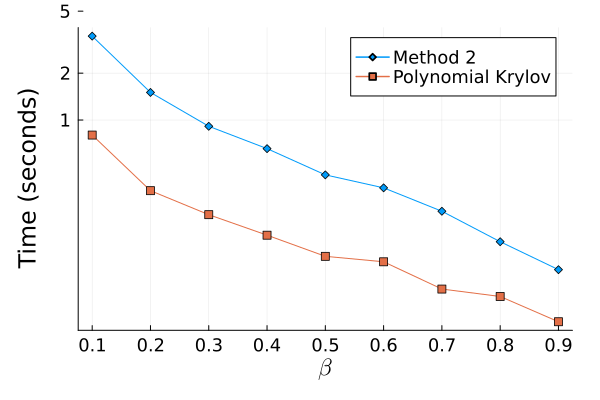

In [11]:
p5 = plot(βvec[1:9],t1[1:9],marker=:diamond,label=:"Method 2",yaxis=:log,  margin=5Plots.mm)
plot!(βvec[1:9],t2[1:9],marker=:square,label=:"Polynomial Krylov", yaxis=:log)
xticks!([0.1; 0.2; 0.3; 0.4; 0.5; 0.6; 0.7; 0.8; 0.9], string.([0.1; 0.2; 0.3; 0.4; 0.5; 0.6; 0.7; 0.8; 0.9]))
yticks!([1; 2; 5;10], string.([1; 2; 5;10]))
xlabel!(L"\beta")
ylabel!("Time (seconds)")

In [ ]:
size(W2)

In [13]:
savefig(p5,"timings_beta_shortint_1_rnk5.pdf")

"/home/hdw27/Documents/AkhiezerSylvester/Notebooks/timings_beta_shortint_1_rnk5.pdf"

In [ ]:
p6 = plot(βvec,i3,marker=:circle,label=:"Method 1",color=3,yaxis=:log, xaxis=:log)
plot!(βvec,i1,marker=:diamond,label=:"Method 2",color=1)
plot!(βvec,i2,marker=:square,label=:"Polynomial Krylov",color=2)
xticks!([0.2; 0.3; 0.4; 0.5; 0.6; 0.7; 0.8; 0.9], string.([0.2; 0.3; 0.4; 0.5; 0.6; 0.7; 0.8; 0.9]))
yticks!([10; 25; 50; 100; 150], string.([10; 25; 50; 100; 150]))
xlabel!(L"\beta")
ylabel!("Iterations")

In [ ]:
#savefig(p6,"timings_new2.pdf")

### Integral equations

In [ ]:
n = 2000
gd = JacobiMappedInterval(-1,1,0,0)
sp = Jacobi(0,0,gd)
K1 = (x,y) -> exp(-2abs(x-y))
x = gd.grid(n)
KM1 = K1.(x,x')
a, b = OperatorApproximation.Jacobi_ab(0.0,0.0)
w = 2OperatorApproximation.Gauss_quad(a,b,n-1)[2]
W = diagm(sqrt.(w))
A = W*KM1*W
#id = Matrix(I,n,n)
Ff(x) = cos(4x)/sqrt(1.04-x^2)
Fg(x) = sin(20x)
f = (x,y) -> Ff(x)*Fg(y)
F = f.(x,x')
FF = W*Ff.(x)
FG = transpose(W*Fg.(x)) |> Array;

In [ ]:
eval1 = opnorm(A)#norm(W*K1.(x,0))^2
evalrangeIA = [1.0-0.1 1+eval1+0.1]
bands = [-reverse(evalrangeIA); evalrangeIA]

Utru = sylvester(I+A,I+A,-FF*FG);

In [ ]:
param = get_params_inv(bands,I+A,-(I+A))

In [ ]:
Wk, Zk, errs = sylv_operator_inv_low_rank(I+A,FF,FG,-(I+A),param; get_resid=true, tru_sol=Utru)
Up = Wk*Zk
U = W\Up/W;

In [ ]:
p1 = plot(errs,yaxis=:log,label="Errors")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{U}_k-\mathbf{U}_*\Vert_2")
plot!(0:param.maxiter-1,((40n*(1-param.conv_rate))*param.conv_rate.^(0:param.maxiter-1)),label="Reference line")

In [ ]:
savefig(p1,"int_eqn_err.pdf")

In [ ]:
p2 = contourf(x, x, real.(U'), levels=20, color=:turbo, right_margin=20Plots.px)
xlabel!(L"x")
ylabel!(L"y")

In [ ]:
savefig(p2,"int_eqn_sol.pdf")

In [ ]:
# Add extra term to integral equation
n = 2000
gd = JacobiMappedInterval(-1,1,0,0)
sp = Jacobi(0,0,gd)
K1 = (x,y) -> exp(-2abs(x-y))
x = gd.grid(n)
KM1 = K1.(x,x')
a, b = OperatorApproximation.Jacobi_ab(0.0,0.0)
w = 2OperatorApproximation.Gauss_quad(a,b,n-1)[2]
W = diagm(sqrt.(w))
A = W*KM1*W
id = Matrix(I,n,n)
Ff(x) = x^2
Fg(x) = -exp(x)
f = (x,y) -> Ff(x)*Fg(y)
#F = f.(x,x')
FF = W*Ff.(x)
FG = transpose(W*Fg.(x)) |> Array

K2 = (x,y) -> cos(20x)*exp(y)
KM2 = K2.(x,x')
#W = diagm(sqrt.(w))
B1 = W*KM2*W

#other kernel in low-rank form
# K₄(x,y)=cosh(x)sinh(y)
u2 = W*sinh.(x)
v2 = cosh.(x')*W;

In [ ]:
eval1 = opnorm(A)
evalrangeIA = [1.0-0.1 1+eval1+0.1]
bands = [-reverse(evalrangeIA); evalrangeIA];

In [ ]:
param = get_params_inv(bands,I+A,-(I+A))

function precondB(x)
    X = reshape(x,n,n)
    U = B1*X*u2
    V = v2
    Wk,Zk = sylv_operator_inv_low_rank(I+A,U,V,-(I+A),param)
    return x+vec(Wk*Zk)
end

Bt = LinearMap(x -> precondB(x), n^2; issymmetric=false, ismutating=false)

In [ ]:
Wk, Zk = sylv_operator_inv_low_rank(I+A,FF,FG,-(I+A),param)
new_rhs = vec(Wk*Zk);

In [ ]:
(vecsol,hist) = gmres(Bt, new_rhs;log=true)
Up = reshape(vecsol,n,n)
U = W\Up/W
hist

In [ ]:
p3 = contourf(x, x, real.(U'), levels=20, color=:turbo, right_margin=25Plots.px)
xlabel!(L"x")
ylabel!(L"y")

In [ ]:
savefig(p3,"int_eqn_sol2a.pdf")

In [ ]:
n = 2000
gd = JacobiMappedInterval(-1,1,0,0)
sp = Jacobi(0,0,gd)
K1 = (x,y) -> exp(-(x-y)^2)
x = gd.grid(n)
KM1 = K1.(x,x')
a, b = OperatorApproximation.Jacobi_ab(0.0,0.0)
w = 2OperatorApproximation.Gauss_quad(a,b,n-1)[2]
W = diagm(sqrt.(w))
A = W*KM1*W
#id = Matrix(I,n,n)
Ff(x) = 1/(x^4+2)
Fg(x) = -sin(10x)
f = (x,y) -> Ff(x)*Fg(y)
#F = f.(x,x')
FF = W*Ff.(x)
FG = transpose(W*Fg.(x)) |> Array

K2 = (x,y) -> y*sech(x)^2
KM2 = K2.(x,x')
B1 = W*KM2*W

#other kernel in low-rank form
# K₄ = exp(x-y)
u2 = W*exp.(-x)
v2 = exp.(x')*W;

In [ ]:
eval1 = opnorm(A)
evalrangeIA = [1.0-0.1 1+eval1+0.1]
bands = [-reverse(evalrangeIA); evalrangeIA]

In [ ]:
param = get_params_inv(bands,I+A,-(I+A))

Wk, Zk = sylv_operator_inv_low_rank(I+A,FF,FG,-(I+A),param)
new_rhs = vec(Wk*Zk);

In [ ]:
(vecsol,hist) = gmres(Bt, new_rhs;log=true)
Up = reshape(vecsol,n,n)
U = W\Up/W
hist

In [ ]:
p4 = contourf(x, x, real.(U'), color=:turbo, right_margin=26Plots.px)
xlabel!(L"x")
ylabel!(L"y")

In [ ]:
savefig(p4,"int_eqn_sol2b.pdf")

### Poisson/Helmholtz equation example

In [ ]:
function Jacobi_ab(a,b)
    bfun = n -> (a+b==-1 && n==0) ? √(2*a*b) :
        2*sqrt(n+1)*sqrt(n+a+1)*sqrt(n+b+1)*sqrt(n+a+b+1)/
        ((2n + a +b + 2)*sqrt(2n + a +b + 3)*sqrt(2n + a +b + 1))
    afun = n -> ((a+b==0 || a+b==-1) && n==0) ? (b-a)/(a+b+2) :
        (b^2 - a^2)/((2n + a +b + 2)*(2n + a +b))
    return (n -> n < 0 ? a : afun(n),n -> n < 0 ? b : bfun(n))  # this is not needed but lets us get access to the Jacobi parameters after the fact
end

function d(j,λ)
    j*sqrt(2*(j + 2λ)/j*(λ+1)/(2λ+1))
end

function Diff(λ,n)
    Bidiagonal(fill(0.0,n),[d(j,λ) for j=1:n-1], :U)
end

function poly(a,b,n,x) # a naive use of the three-term recurrence
    p = fill(0.0im,n)
    p[1] = 1.0 # p_0
    p[2] = x.*p[1] - a(0)*p[1] # compute p_1
    p[2] /= b(0)
    for j = 1:n-2 # compute p_n
        p[j+2] = x.*p[j+1] - a(j)*p[j+1] - b(j-1)*p[j]
        p[j+2] /= b(j)
    end
    p
end

function poly(a,b,n,z::Vector)
    vcat(map(zz -> poly(a,b,n,zz) |> transpose , z)...)
end

function poly(λ::Number,n,z::Vector)
    a, b = Jacobi_ab(λ - 0.5,λ - 0.5)
    poly(a,b,n,z)
end

Tgrid = n -> -cos.( (2*(1:n) .- 1)/(2*n) * pi )

In [ ]:
n = 20
xgrid = Tgrid(n - 2)
ED₂ = poly(2.0,n,xgrid)*(Diff(1.0,n)*Diff(0.0,n))
B = poly(0.0,n,[-1.0,1.0])
Q, ~ = qr(B')
T = Q[:,3:end]
ET = poly(0.0,n,xgrid)*T
A = ET\(ED₂*T)-(49/2)I

Ff(x) = cos(x)
Fg(x) = sin(x)
FF = ET\Ff.(xgrid)
FG = transpose(ET\Fg.(xgrid)) |> Array

end1 = eigmin(real(A))-100.
end2 = eigmax(real(A))+1
evalrangeA = [end1 end2]
bands = [evalrangeA; -reverse(evalrangeA)]

In [ ]:
param = get_params(bands,-A'|>Array,A; tol=1e-6, unbounded_op=true, num_quad_pts=5000);

In [ ]:
tsol = sylvester(A,A',-FF*FG)
W,Z,erv = lowrank_block_svd(-A'|>Array,-FF,FG,A,param;get_resid=true,tru_sol=tsol);

In [ ]:
p0 = plot(erv,yaxis=:log,label="Errors")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{Y}_k-\mathbf{Y}_*\Vert_2")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
plot!(0:param.maxiter-1,((10(n-2)*(1-1/param.conv_rate))*param.conv_rate.^(-(0:param.maxiter-1))),label="Reference line")

In [ ]:
savefig(p0,"helmholtz_err.pdf")

In [ ]:
Y = W*Z
X = T*Y*T';

In [ ]:
x = -1:0.01:1 |> Array#[-1; xgrid; 1]
XX = poly(0.0,n,x)*X*poly(0.0,n,x)'
p1 = contourf(x, x, real.(XX'), color=:turbo, right_margin=46Plots.px)
xlabel!(L"x")
ylabel!(L"y")

In [ ]:
savefig(p1,"helmholtz.pdf")

In [ ]:
n = 10
xgrid = Tgrid(n - 2)
ED₂ = poly(2.0,n,xgrid)*(Diff(1.0,n)*Diff(0.0,n))
B = poly(0.0,n,[-1.0,1.0])
Q, ~ = qr(B')
T = Q[:,3:end]
ET = poly(0.0,n,xgrid)*T
A = ET\(ED₂*T)

Ff(x) = cos(4x)
Fg(x) = sign(x)
FF = ET\Ff.(xgrid)
FG = transpose(ET\Fg.(xgrid)) |> Array

end1 = eigmin(real(A))-100.
end2 = eigmax(real(A))+0.1
evalrangeA = [end1 end2]
bands = [evalrangeA; -reverse(evalrangeA)]

In [ ]:
param = get_params(bands,-A'|>Array,A; tol=1e-10, unbounded_op=true, num_quad_pts=5000);

In [ ]:
tsol = sylvester(A,A',-FF*FG)
W,Z,erv = lowrank_block_svd(-A'|>Array,-FF,FG,A,param;get_resid=true,tru_sol=tsol);

In [ ]:
p2 = plot(erv,yaxis=:log,label="Errors", right_margin=10Plots.px)
xlabel!(L"k")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
ylabel!(L"\Vert \mathbf{Y}_k-\mathbf{Y}_*\Vert_2")
plot!(0:param.maxiter-1,((10(n-2)*(1-1/param.conv_rate))*param.conv_rate.^(-(0:param.maxiter-1))),label="Reference line")

In [ ]:
savefig(p2,"poisson_error.pdf")

In [ ]:
Y = W*Z
X = T*Y*T'

x = -1:0.01:1 |> Array#[-1; xgrid; 1]
XX = poly(0.0,n,x)*X*poly(0.0,n,x)'

p3 = contourf(x, x, real.(XX'), color=:turbo, right_margin=35Plots.px)
xlabel!(L"x")
ylabel!(L"y")

In [ ]:
savefig(p3,"poisson.pdf")

### Fr\'echet derivatives

In [ ]:
M = (a,b) ->  (x -> (b-a)/2*(x .+ (b+a)/(b-a)))

In [ ]:
function sign_newton(X;maxiter=20)
    Xk = X
    for k = 1:maxiter
        Xk = (Xk+inv(Xk))/2
    end
    Xk
end

In [ ]:
function frec_newton(X,E;maxiter=20) #computes Frechet derivative of sign function
    Xk = X
    Ek = E
    for k = 1:maxiter
        Ek = (Ek-Xk\Ek/Xk)/2
        Xk = (Xk+inv(Xk))/2
    end
    Ek
end

In [ ]:
Random.seed!(123)
#generate matrix A
N = 200
bands = [-2. -0.5; 0.5 6.]
n₁ = ceil(N*(bands[1,2]-bands[1,1])/(bands[1,2]-bands[1,1]+bands[2,2]-bands[2,1])) |> Int
μ₁ = M(bands[1,1],bands[1,2])(2*0.9*rand(n₁).-1)
μ₂ = M(bands[2,1],bands[2,2])(2*0.9*rand(N-n₁).-1)
Ad = diagm([μ₁; μ₂])
P = rand(N,N)
Q,R = qr(P)
A = Q\(Ad*Q)

#generate E=E1*E2
r = 4 #rank of E
E1 = randn(N,r)
E2 = randn(r,N)
E = E1*E2

block_mat = [A zeros(N,N); E A]
truLb = frec_newton(A,E);#sign_newton(block_mat)[N+1:end,1:N];

In [ ]:
param = get_params(bands,A,A);

In [ ]:
W,Z,erv = lowrank_block_svd(A,E1,E2,A,param; get_resid=true, tru_sol=truLb/2)
L = 2W*Z;

In [ ]:
p0 = plot(2erv,yaxis=:log,label="Errors")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{L}_k-L_{\mathrm{sign}}(\mathbf{A},\mathbf{E})\Vert_2")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
plot!(0:param.maxiter-1,((20N*(1-1/param.conv_rate))*param.conv_rate.^(-(0:param.maxiter-1))),label="Reference line")

In [ ]:
savefig(p0,"sign-frechet.pdf")

In [ ]:
numiter = 25
num_quad_pts = 800

cc(j) = (bands[j,1]+bands[j,2])/2
rr(j) = 1.25*(bands[j,2]-bands[j,1])/2

ctrpts = [] #quadrature nodes
ptsper = [0; 0]
weights = [] #quadrature weights
total_length = sum(bands[:,2]-bands[:,1])
for j = 1:2
    ptsper[j] = round(num_quad_pts*(bands[j,2]-bands[j,1])/total_length)
    append!(ctrpts,rr(j)*zgrid(ptsper[j]).+cc(j) .|> Complex)
    append!(weights,2π*im*rr(j)*(zgrid(ptsper[j]))/ptsper[j] .|> Complex)
end

(avec,bvec,ints) = get_n_coeffs_and_ints_akh(bands, numiter, ctrpts)

α = zeros(ComplexF64,numiter+1)
for j = 1:length(ctrpts)
    α -= exp(ctrpts[j])*weights[j]*ints[:,j]
end

truLexp = exp(block_mat)[N+1:end,1:N];

In [ ]:
W,Z,erv = lowrank_block_svd(A,E1,E2,A,2α,avec,bvec,numiter; get_resid=true, tru_sol=truLexp)
L = W*Z;

In [ ]:
p1 = plot(erv,yaxis=:log,label="Errors")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
yaxis!([1e-12,11000])
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{L}_k-L_{\exp}(\mathbf{A},\mathbf{E})\Vert_2")
#plot!(0:param.maxiter-1,((10N*(1-1/param.conv_rate))*param.conv_rate.^(-(0:param.maxiter-1))),label="Reference line")

In [ ]:
savefig(p1,"exp-frechet.pdf")

### Eigenvalues off intervals

In [ ]:
bands = [-2 -0.5; 0.5 6]

Random.seed!(123)

#generate dense positive definite matrices with eigenvalues 
evalrangeA = [0.5 6.] #eigenvalues of A
evalrangeB = [0.5 2.] #eigenvalues of B
N, N₂ = 300, 100 #dimensions of A and B
r = 2 #rank of RHS

#generate B
μ2 = M(evalrangeB[1],evalrangeB[2])(0.8*(2rand(N₂).-1))
D = diagm(μ2)+randn(N₂,N₂)/sqrt(N₂)
P = rand(N₂,N₂)
Q,R = qr(P)
B = Q\(D*Q);
B = -B

#generate A
μ = M(evalrangeA[1],evalrangeA[2])(0.95*(2rand(N).-1))
A = diagm(μ)+randn(N,N)/sqrt(N)
P = rand(N,N)
Q,R = qr(P)
A = Q\(A*Q)

bands = [-reverse(evalrangeB); evalrangeA] #eigenvalues of block system

#generate RHS
U = randn(N₂,r)
V = randn(r,N)

H = [A zeros(N,N₂); zeros(N₂,N) B];

In [ ]:
g0 = golden_section(bands)

xv = bands[1,1]-0.2:0.01:bands[end,2]+0.2
yv = LinRange(-1.,1.,length(xv))
make_mat(x, y) = x+im*y
zv = @. make_mat(xv', yv);
gzp = map(z->get_n_coeffs_and_ints_akh(bands, 0, z)[4][1],zv);

In [ ]:
p1 = contour(xv, yv, real.(gzp), levels=[0.005; 0.1; 0.17; 0.25], color=:black,colorbar=false)
contour!(xv, yv, real.(gzp), levels=[g0], linecolor=:red, linestyle=:dash, colorbar=false)
xlabel!(L"\mathrm{Re}(z)")
ylabel!(L"\mathrm{Im}(z)")
plot!(eigvals(H),seriestype=:scatter,label=:false)
worst_eig = -1.6287090008859226 + 0.15421322082385427im
plot!([worst_eig; conj(worst_eig)],seriestype=:scatter,label=:false)

In [ ]:
savefig(p1,"eigvals_bern.pdf")

In [ ]:
egt = exp(g0)
ge = real(get_n_coeffs_and_ints_akh(bands, 0, worst_eig)[4][1])
param = get_params(bands,A,B; gt = g0-ge, num_quad_pts=1500)
tru_sln = sylvester(-B,A,-U*V);

In [ ]:
W,Z,erv = lowrank_block_svd(A,U,V,B,param; get_resid=true, tru_sol=tru_sln)

In [ ]:
p2 = plot(2erv,yaxis=:log,label="Errors")
xlabel!(L"k")
ylabel!(L"\Vert \mathbf{X}_k-\mathbf{X}_*\Vert_2")
yticks!([10^0, 10^-2, 10^-4, 10^-6, 10^-8, 10^-10, 10^-12, 10^-14])
yaxis!([1e-16,3000])
plot!(0:param.maxiter-1,((10(N+N₂)*(1-1/param.conv_rate))*param.conv_rate.^(-(0:param.maxiter-1))),label="True reference line")
plot!(0:param.maxiter-1,((10(N+N₂)*(1-1/egt))*egt.^(-(0:param.maxiter-1))),label="Naive reference line", linestyle=:dash)

In [ ]:
savefig(p2,"eig_conv.pdf")